# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [3]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [4]:
# Importing the file porter_data_1.csv
df = pd.read_csv(r"C:\LR_Delivery_Time_Prediction_SPARSHIT_GEDAM\porter_data_1.csv")
df.head(3)

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56


## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [5]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], errors='coerce')


df[['created_at', 'actual_delivery_time']].head()


,created_at,actual_delivery_time
0,2015-02-06 22:24:17,2015-02-06 23:11:17
1,2015-02-10 21:49:25,2015-02-10 22:33:25
2,2015-02-16 00:11:35,2015-02-16 01:06:35
3,2015-02-12 03:36:46,2015-02-12 04:35:46
4,2015-01-27 02:12:36,2015-01-27 02:58:36


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [6]:
# Convert categorical features to category type

categoricals = ['market_id', 'store_primary_category', 'order_protocol']


for col in categoricals:
    df[col] = df[col].astype('category')


df.dtypes[categoricals]


market_id                 category
store_primary_category    category
order_protocol            category
dtype: object

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [7]:

df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], errors='coerce')
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')


df['time_taken'] = df['actual_delivery_time'] - df['created_at']


df['time_taken_minutes'] = df['time_taken'].dt.total_seconds() / 60


print(df[['created_at', 'actual_delivery_time', 'time_taken', 'time_taken_minutes']].head())

           created_at actual_delivery_time      time_taken  time_taken_minutes
0 2015-02-06 22:24:17  2015-02-06 23:11:17 0 days 00:47:00                47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25 0 days 00:44:00                44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35 0 days 00:55:00                55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46 0 days 00:59:00                59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36 0 days 00:46:00                46.0


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [8]:
# Extract the hour and day of week from the 'created_at' timestamp


df['created_hour'] = df['created_at'].dt.hour
df['created_dayofweek'] = df['created_at'].dt.dayofweek  # Monday=0, Sunday=6


df[['created_at', 'created_hour', 'created_dayofweek']].head()


,created_at,created_hour,created_dayofweek
0,2015-02-06 22:24:17,22,4
1,2015-02-10 21:49:25,21,1
2,2015-02-16 00:11:35,0,0
3,2015-02-12 03:36:46,3,3
4,2015-01-27 02:12:36,2,1


In [9]:
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance,time_taken,time_taken_minutes,created_hour,created_dayofweek
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44,0 days 00:47:00,47.0,22,4
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60,0 days 00:44:00,44.0,21,1
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56,0 days 00:55:00,55.0,0,0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80,0 days 00:59:00,59.0,3,3
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20,0 days 00:46:00,46.0,2,1


In [10]:
# Drop unnecessary columns

columns_to_drop = ['created_at', 'actual_delivery_time']
df_cleaned = df.drop(columns=columns_to_drop)


df_cleaned.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'time_taken',
       'time_taken_minutes', 'created_hour', 'created_dayofweek'],
      dtype='object')

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [11]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype          
---  ------                    --------------   -----          
 0   market_id                 175777 non-null  category       
 1   store_primary_category    175777 non-null  category       
 2   order_protocol            175777 non-null  category       
 3   total_items               175777 non-null  int64          
 4   subtotal                  175777 non-null  int64          
 5   num_distinct_items        175777 non-null  int64          
 6   min_item_price            175777 non-null  int64          
 7   max_item_price            175777 non-null  int64          
 8   total_onshift_dashers     175777 non-null  float64        
 9   total_busy_dashers        175777 non-null  float64        
 10  total_outstanding_orders  175777 non-null  float64        
 11  distance                  175777 non-null  float64  

In [12]:
# Define target variable (y) and features (X)

X = df_cleaned.drop(columns=['time_taken_minutes'])
y = df_cleaned['time_taken_minutes']


X.shape, y.shape

((175777, 15), (175777,))

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [13]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (140621, 15) (140621,)
Testing set: (35156, 15) (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


#### Define numerical and categorical columns for easy EDA and data manipulation

numerical variables are those which mostly contains continous values which cannot be categorised in some fixed values , on the other hand
categorical coulmns are those which take limited and certain values.

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

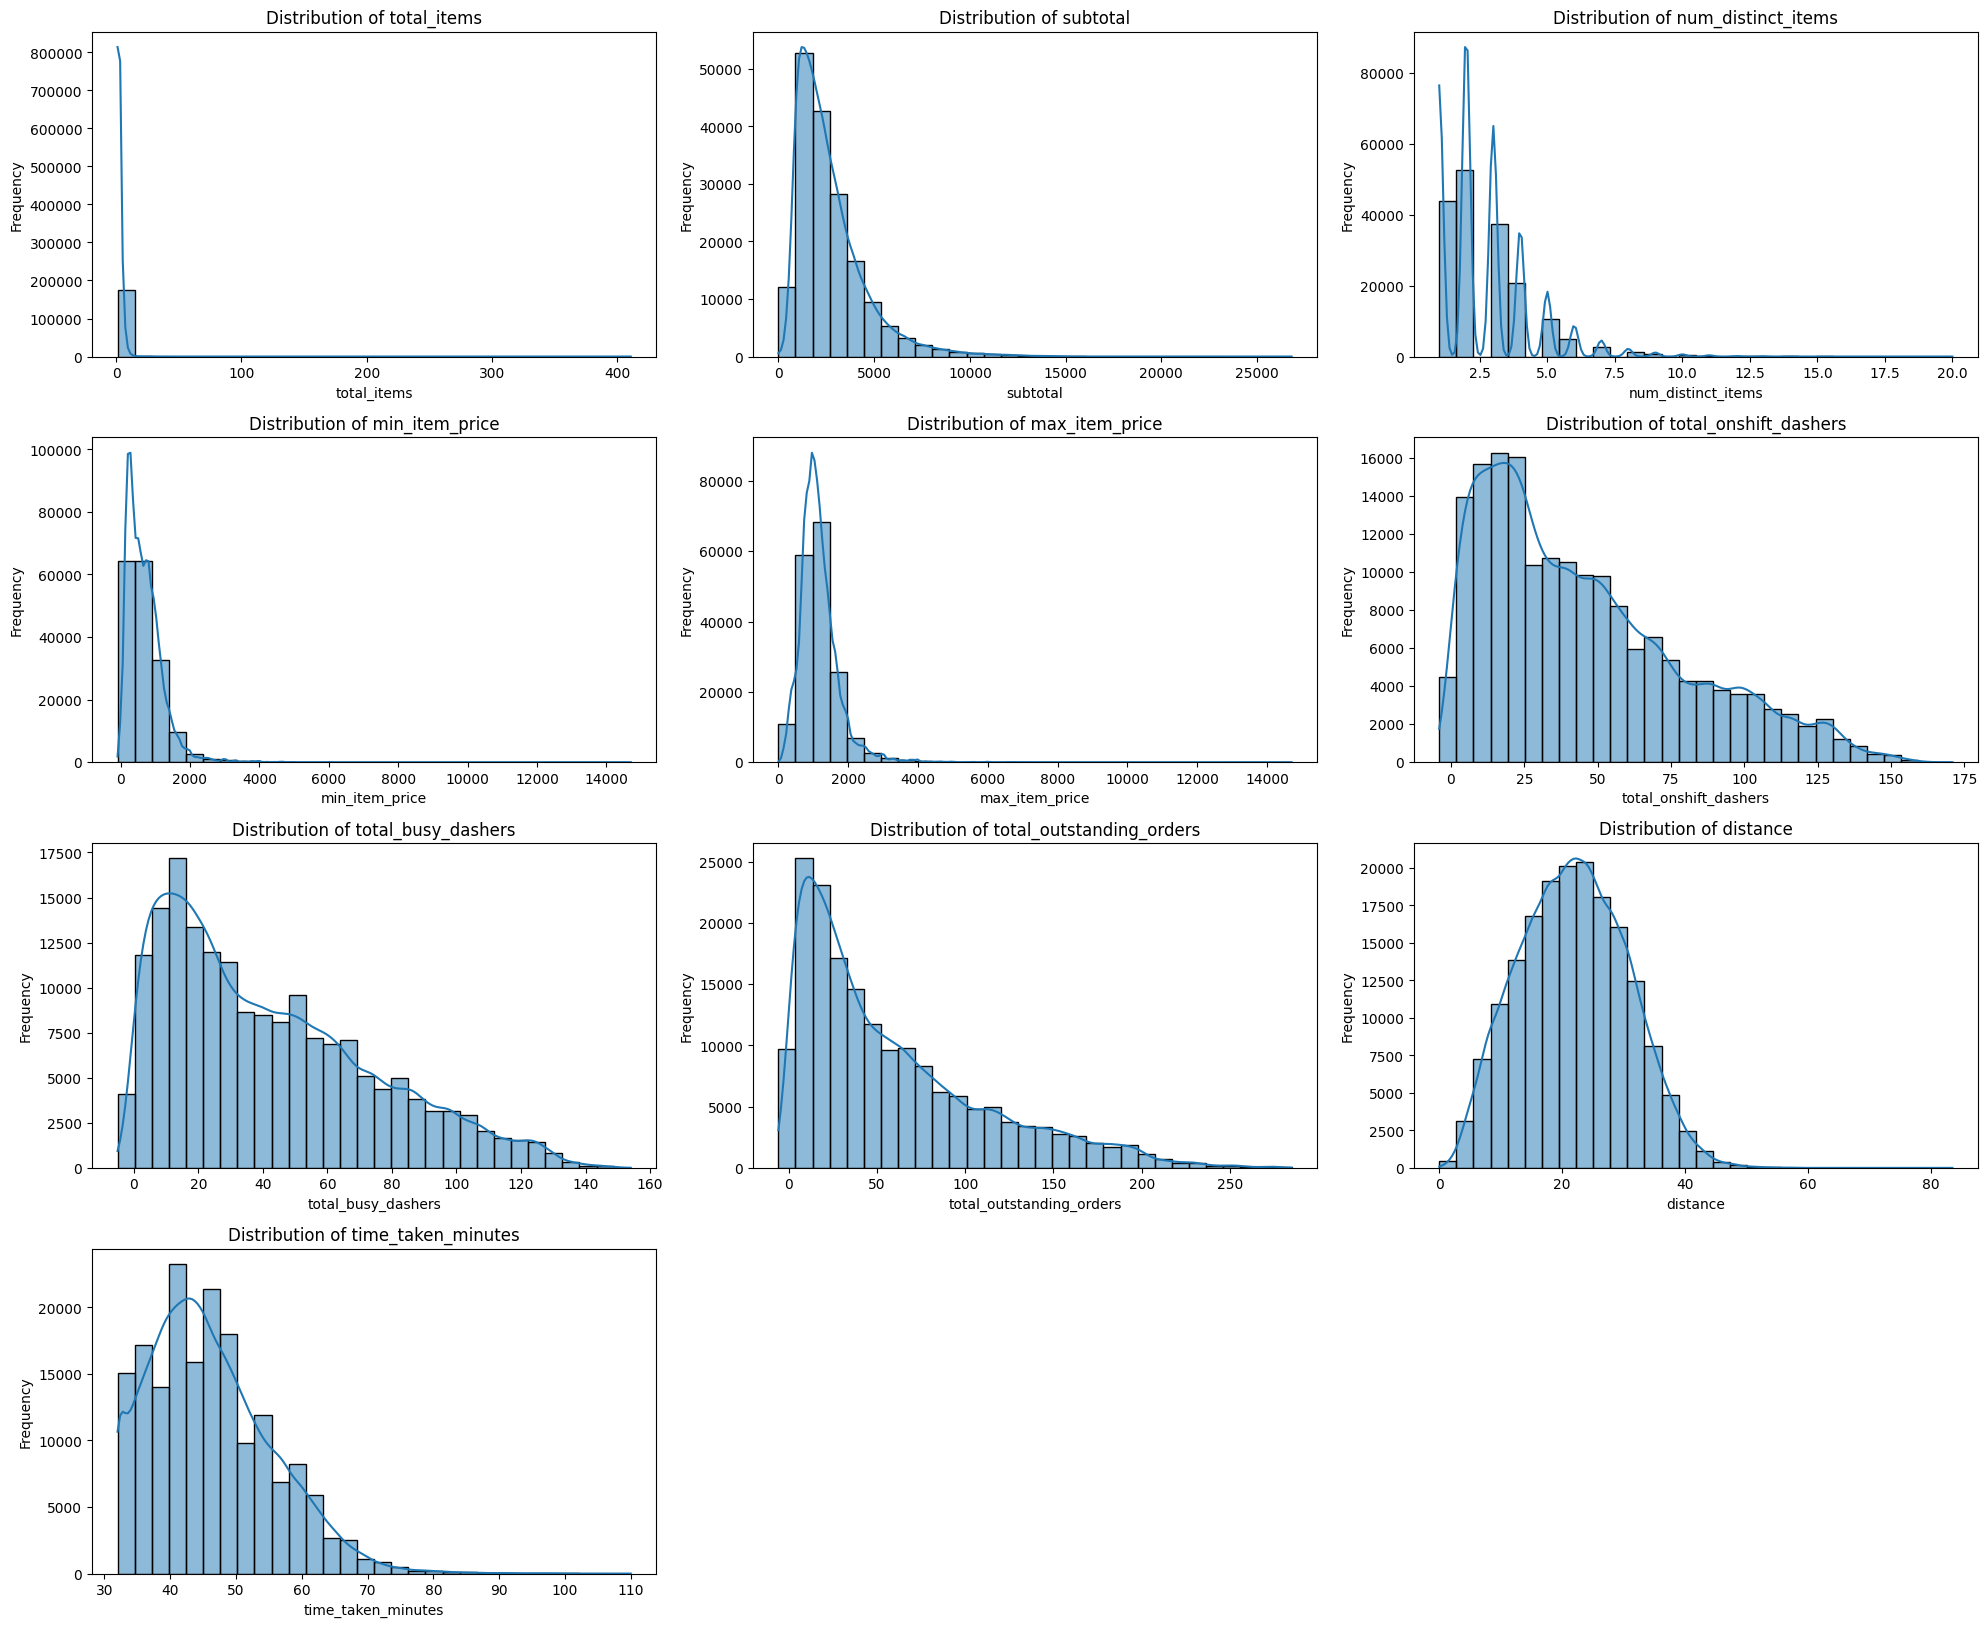

In [14]:
# Plot distributions for all numerical columns



numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()


plt.figure(figsize=(20, 20))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 3, i)
    sns.histplot(df_cleaned[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

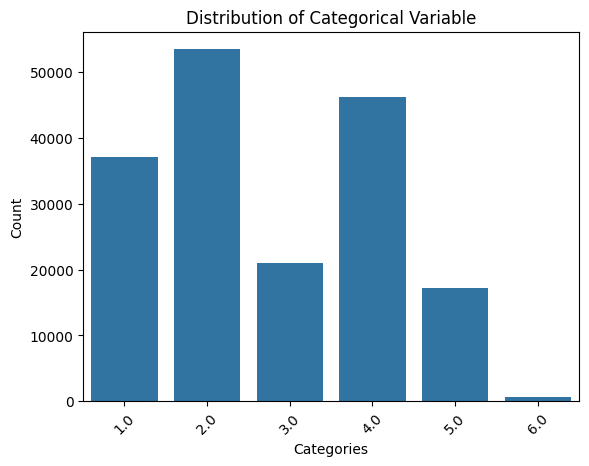

In [17]:
# Distribution of categorical columns

sns.countplot(x='market_id', data=df_cleaned)
plt.title('Distribution of Categorical Variable')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()

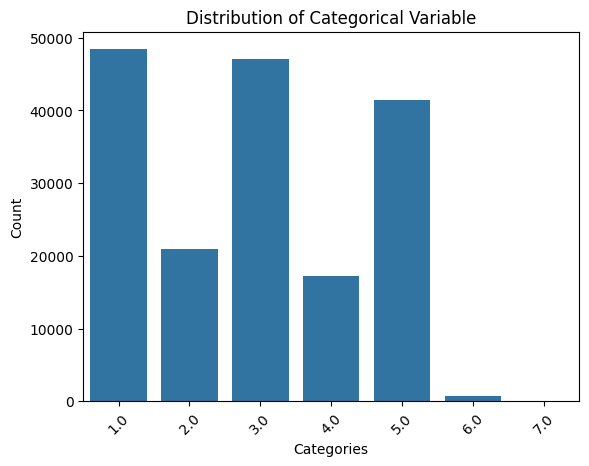

In [20]:
sns.countplot(x='order_protocol', data=df)
plt.title('Distribution of Categorical Variable')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

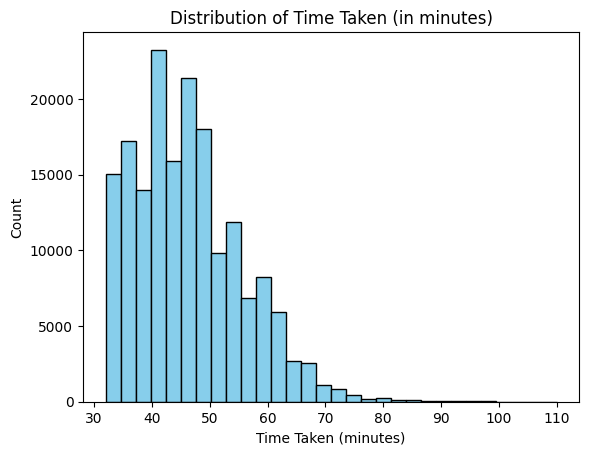

In [22]:
# Distribution of time_taken

df['time_taken_minutes'] = df['time_taken'].dt.total_seconds() / 60


plt.hist(df['time_taken_minutes'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Time Taken (in minutes)')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Count')
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

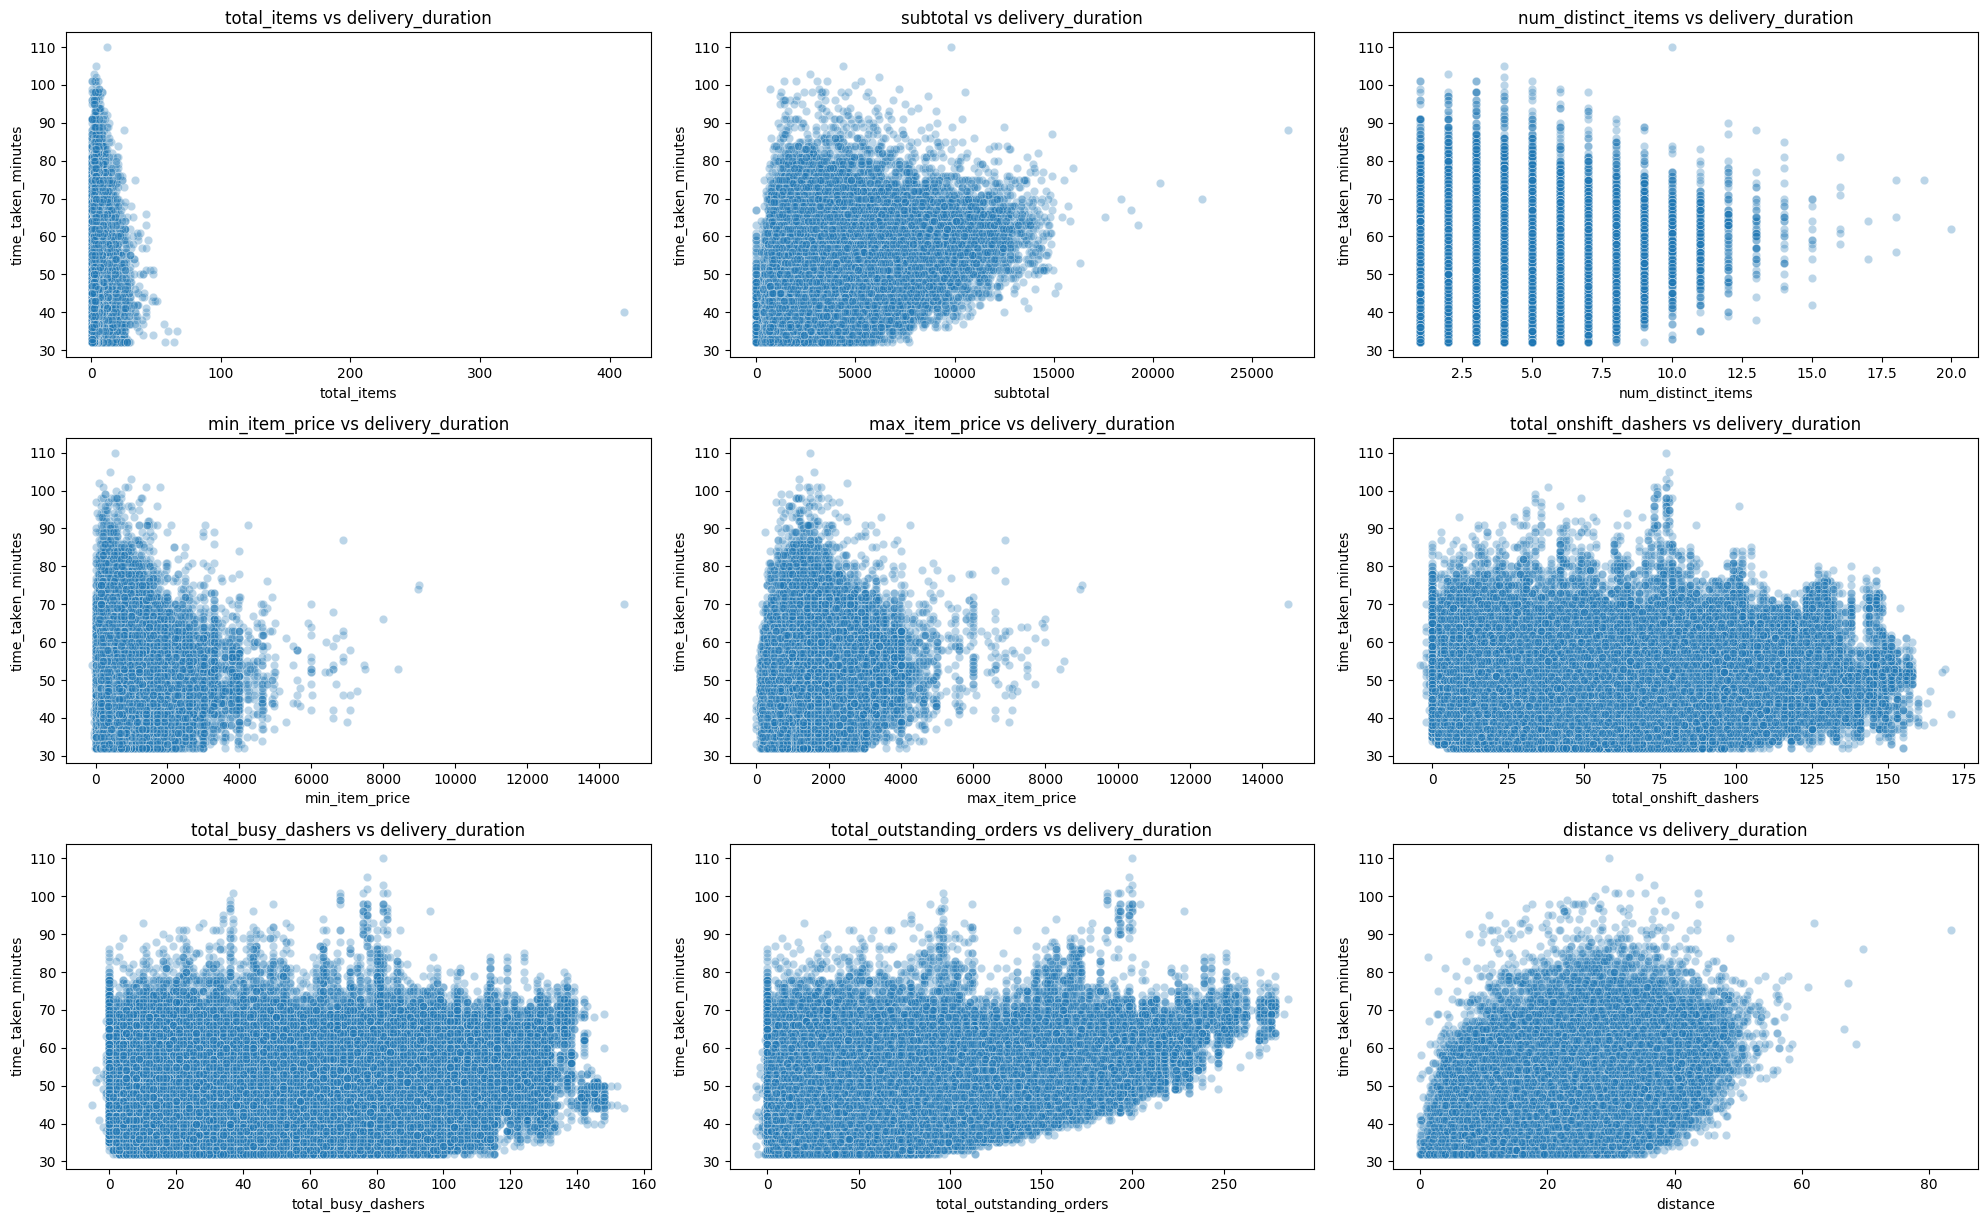

In [23]:
# Scatter plot to visualise the relationship between time_taken and other features


plt.figure(figsize=(20, 20))


numerical_features = [col for col in numerical_cols if col != 'time_taken_minutes']

for i, col in enumerate(numerical_features, 1):
    plt.subplot(5, 3, i)
    sns.scatterplot(data=df_cleaned, x=col, y='time_taken_minutes', alpha=0.3)
    plt.title(f'{col} vs delivery_duration')
    plt.xlabel(col)
    plt.ylabel('time_taken_minutes')

plt.tight_layout()
plt.show()


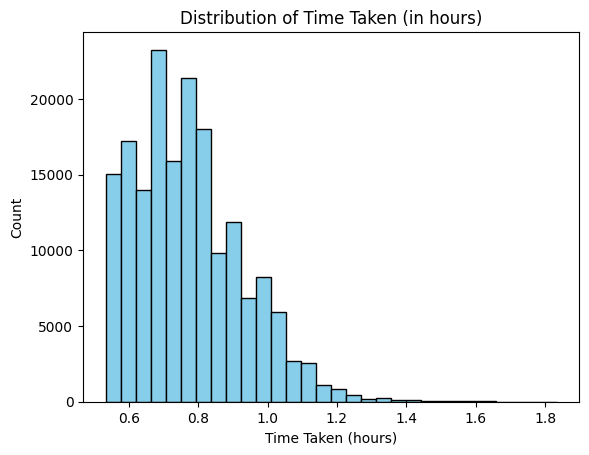

In [24]:
# Show the distribution of time_taken for different hours

df['time_taken_hours'] = df['time_taken'].dt.total_seconds() / 3600


plt.hist(df['time_taken_hours'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Time Taken (in hours)')
plt.xlabel('Time Taken (hours)')
plt.ylabel('Count')
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

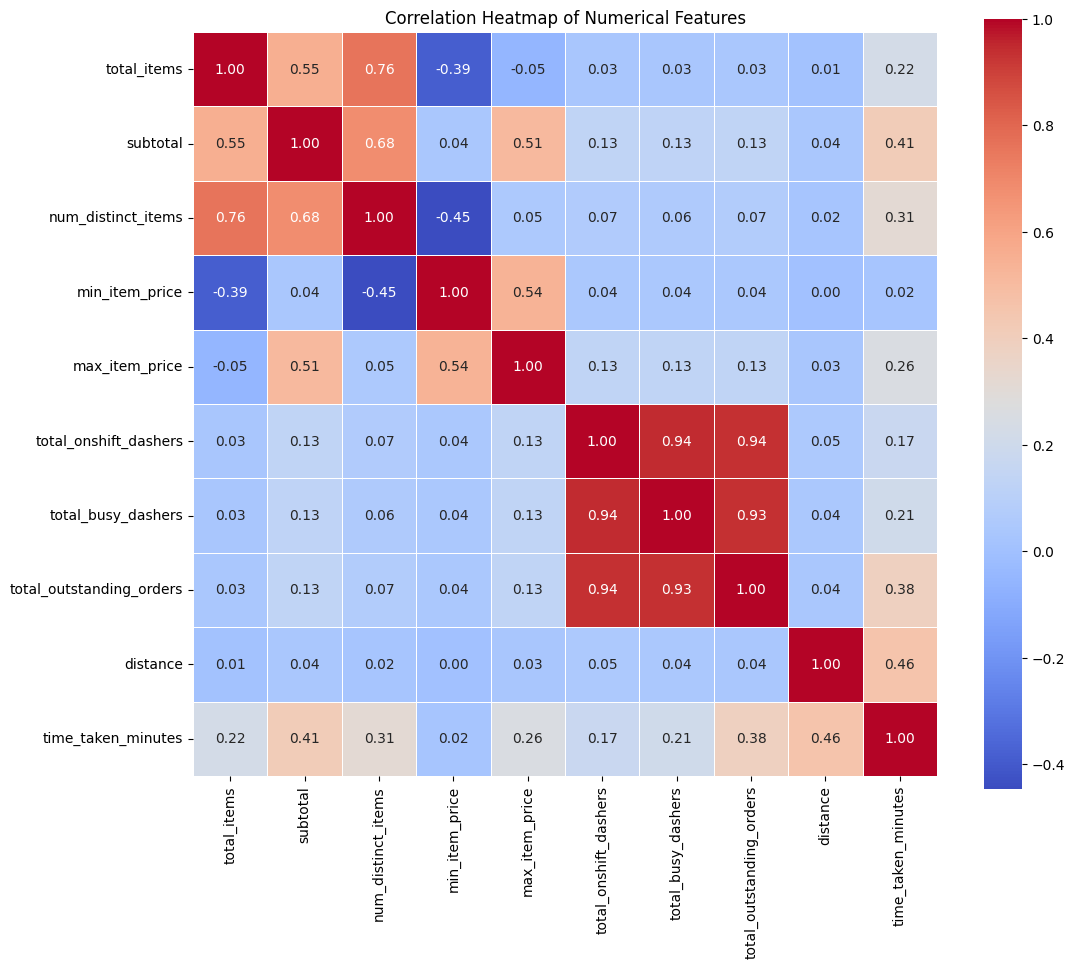

In [25]:
# Plot the heatmap of the correlation matrix

correlation_matrix = df_cleaned[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [26]:
# Drop 3-5 weakly correlated columns from training dataset

cor_target = correlation_matrix['time_taken_minutes'].abs()
weak_correlated_cols = cor_target[cor_target < 0.1].index.tolist()


cols_to_drop = weak_correlated_cols[:5]
X_reduced = X.drop(columns=cols_to_drop)

cols_to_drop, X_reduced.shape

(['min_item_price'], (175777, 14))

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

In [27]:
df_cleaned.head(2)

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance,time_taken,time_taken_minutes,created_hour,created_dayofweek
0,1.0,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44,0 days 00:47:00,47.0,22,4
1,2.0,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60,0 days 00:44:00,44.0,21,1


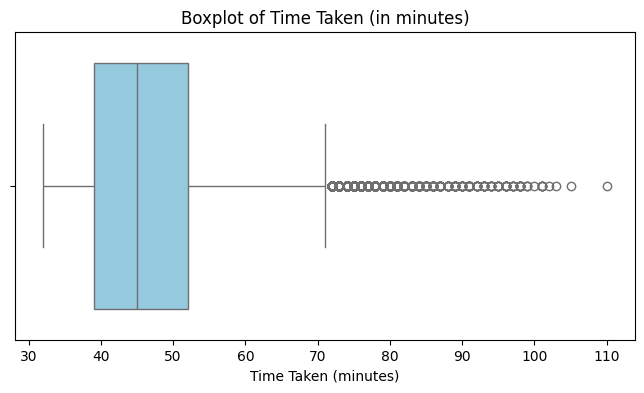

In [28]:
# Boxplot for time_taken


plt.figure(figsize=(8, 4))
sns.boxplot(x=df_cleaned['time_taken_minutes'], color='skyblue')
plt.title('Boxplot of Time Taken (in minutes)')
plt.xlabel('Time Taken (minutes)')
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [29]:
# Handle outliers

Q1 = df_cleaned['time_taken_minutes'].quantile(0.25)
Q3 = df_cleaned['time_taken_minutes'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


df_no_outliers = df_cleaned[(df_cleaned['time_taken_minutes'] >= lower_bound) & (df_cleaned['time_taken_minutes'] <= upper_bound)]

rows_removed = df_cleaned.shape[0] - df_no_outliers.shape[0]
df_no_outliers.shape, rows_removed

((174028, 16), 1749)

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [30]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [31]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [32]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [33]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [34]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [35]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [36]:
# Import libraries
from sklearn.linear_model import LinearRegression


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
# Apply scaling to the numerical columns


numerical_features = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.drop('time_taken_minutes')

scaler = StandardScaler()
df_scaled = df_cleaned.copy()
df_scaled[numerical_features] = scaler.fit_transform(df_cleaned[numerical_features])

df_scaled[numerical_features].head()


,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance
0,0.297311,0.406819,0.815009,-0.246143,0.140581,-0.345022,-0.866110,-0.706040,1.439863
1,-0.824584,-0.435925,-1.030377,1.375380,0.427657,-1.271360,-1.239147,-1.066360,0.658031
2,0.297311,1.134171,0.199880,0.259741,0.791405,-1.068724,-1.114801,-0.762933,-1.175387
3,-0.824584,-0.641006,-1.030377,1.615819,0.650542,-1.155568,-1.114801,-0.952575,1.138103
4,-0.450619,0.504711,-0.415249,1.423468,1.845206,-1.155568,-1.145887,-0.971539,-1.559444


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [39]:
# Create/Initialise the model

from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

In [40]:
df_scaled.drop(columns=['time_taken'], inplace=True)


In [41]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['market_id', 'store_primary_category', 'order_protocol']
df_encoded = pd.get_dummies(df_scaled, columns=categorical_cols, drop_first=True)


df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 95 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   total_items                175777 non-null  float64
 1   subtotal                   175777 non-null  float64
 2   num_distinct_items         175777 non-null  float64
 3   min_item_price             175777 non-null  float64
 4   max_item_price             175777 non-null  float64
 5   total_onshift_dashers      175777 non-null  float64
 6   total_busy_dashers         175777 non-null  float64
 7   total_outstanding_orders   175777 non-null  float64
 8   distance                   175777 non-null  float64
 9   time_taken_minutes         175777 non-null  float64
 10  created_hour               175777 non-null  int32  
 11  created_dayofweek          175777 non-null  int32  
 12  market_id_2.0              175777 non-null  bool   
 13  market_id_3.0              17

In [42]:
# Train the model using the training data

from sklearn.metrics import mean_squared_error, r2_score


X = df_scaled.drop(columns=['time_taken_minutes'])
y = df_scaled['time_taken_minutes']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


y_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(10.598619672998568, 0.8789106758560344)

In [43]:
# Make predictions

y_pred = lr_model.predict(X_test)

print("Sample Predictions:", y_pred[:5])


Sample Predictions: [51.16408135 65.76946718 41.73247987 42.64383272 39.76887142]


In [44]:
# Find results for evaluation metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
 

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 2.35
Mean Squared Error (MSE): 10.60
Root Mean Squared Error (RMSE): 3.26
R² Score: 0.88


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

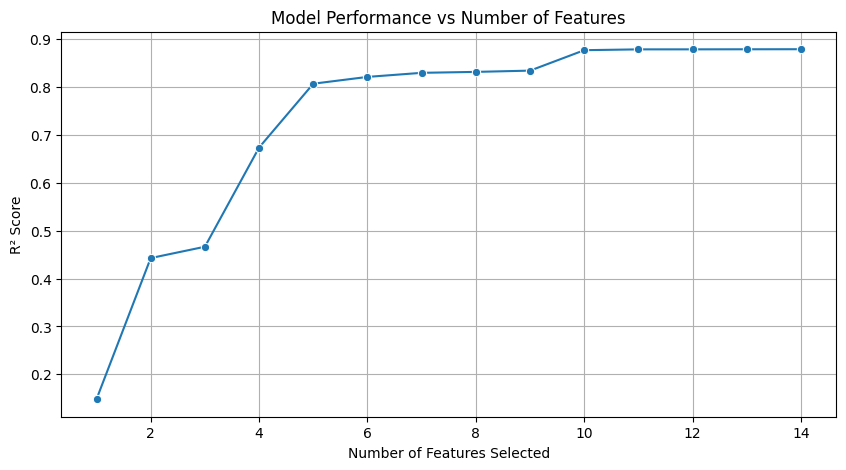

In [45]:
# Loop through the number of features and test the model

from sklearn.feature_selection import RFE


model = LinearRegression()


r2_scores = []


for n_features in range(1, X_train.shape[1] + 1):
    
    selector = RFE(estimator=model, n_features_to_select=n_features)
    selector.fit(X_train, y_train)

    
    X_train_reduced = selector.transform(X_train)
    X_test_reduced = selector.transform(X_test)

    
    model.fit(X_train_reduced, y_train)
    y_pred = model.predict(X_test_reduced)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)


plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, X_train.shape[1] + 1), y=r2_scores, marker='o')
plt.title('Model Performance vs Number of Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('R² Score')
plt.grid(True)
plt.show()

In [46]:
# Build the final model with selected number of features


optimal_features = r2_scores.index(max(r2_scores)) + 1


selector_optimal = RFE(estimator=model, n_features_to_select=optimal_features)
selector_optimal.fit(X_train, y_train)

X_train_opt = selector_optimal.transform(X_train)
X_test_opt = selector_optimal.transform(X_test)

final_model = LinearRegression()
final_model.fit(X_train_opt, y_train)

y_final_pred = final_model.predict(X_test_opt)
final_r2 = r2_score(y_test, y_final_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_final_pred))

final_r2, final_rmse


(0.8789106758560344, np.float64(3.2555521302842885))

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

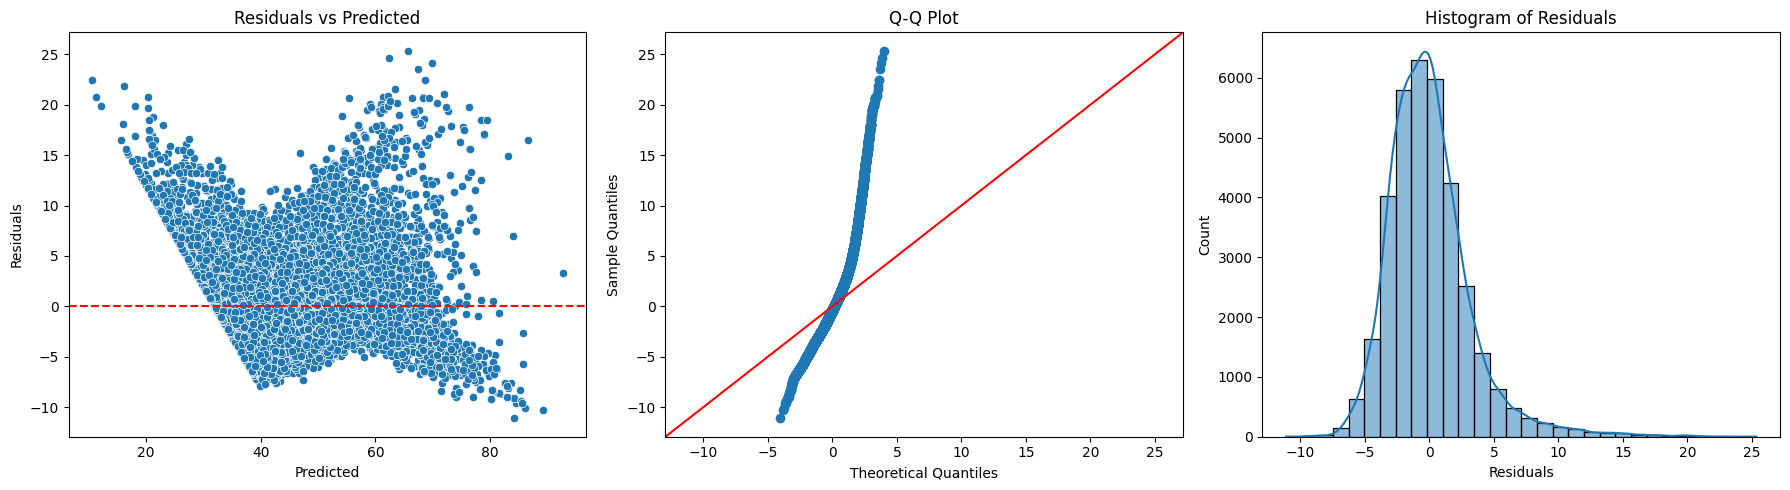

In [47]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram


import statsmodels.api as sm

y_pred = final_model.predict(X_test_opt)
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x=y_pred, y=residuals, ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title("Residuals vs Predicted")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Residuals")


sm.qqplot(residuals, line='45', ax=axes[1])
axes[1].set_title("Q-Q Plot")


sns.histplot(residuals, bins=30, kde=True, ax=axes[2])
axes[2].set_title("Histogram of Residuals")
axes[2].set_xlabel("Residuals")

plt.tight_layout()
plt.show()


[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [48]:
# Compare the scaled vs unscaled features used in the final model



Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [49]:
# Analyze the effect of a unit change in a feature, say 'total_items'



Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
> isWeekend was the categorical data in the dataset after encoding it was turned to numerical



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
> test size of 0.2 means the test size will be 20% and the training set will be 80%



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
> Time_Taken is the target vavriable and it has strong correlation with time_taken_minutes and time_taken_hours



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

> The boxplot plot helped me detecting the outliers , and the InterQuartile method help me remove those outliers 



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
> Linear Regression algorithm work on the basic slope intercept idea. its work here is to reduce those errors and create a best fit line.
> this is done with the help of adjusting the value of intercept and slope
> Linear Regression algorithm creates a very easy and intuitive model for continous numerical values
> it works on some assumption like
> there is linear relationship between target variable and predictor varialbe
> second is multivariate Normalities
> homocadasceacity
> no auto correlartion errors
> no multicollinearity




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
> Simple Liear Regression hass just one predictor variable whereas M.L.R has multiple predictor variable\
> Multiple Linear Regression has higher dimensions than simple regression
> More slope values in Multiple Linear Regression model which imapct the target variable



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
> cost function tell that how worse is the model at prediction
> the goal is to find theta value that minimizes the cost function
> gradient descent is used to minimize the cost function and by small iteration which is multiplied by learning rate




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

> Overfitting is a situation where model tries to learn every thing on training dataset and fails to perform on test dataset
> whereas underfitting is when model poorly perform during training time and then again poorly performs on test data



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>  they help us to know whether the linear model is good
> are there ant outliers or any kind of linear pattern
> and the erros and its spread 